In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# Author: Selvaria
# kaggle钢铁缺陷检测Severstal
# https://www.kaggle.com/c/severstal-steel-defect-detection/overview

import pandas

train_df = pandas.read_csv(r'D:\data\Kaggle\Severstal/train.csv')
train_df['ImageId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
train_df['ClassId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[1])

train_df.head()

,ImageId_ClassId,EncodedPixels,ImageId,ClassId
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg,1
1,0002cc93b.jpg_2,NaN,0002cc93b.jpg,2
2,0002cc93b.jpg_3,NaN,0002cc93b.jpg,3
3,0002cc93b.jpg_4,NaN,0002cc93b.jpg,4
4,00031f466.jpg_1,NaN,00031f466.jpg,1


In [2]:
#将有缺陷（有范围数据）的列做判断，并单独新加一列说明状态（取反），注意这里是pandas的特殊取反，其他python里不一样
train_df['hasMask'] = ~train_df['EncodedPixels'].isnull()
print(len(train_df))
train_df.head()

50272


,ImageId_ClassId,EncodedPixels,ImageId,ClassId,hasMask
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg,1,True
1,0002cc93b.jpg_2,NaN,0002cc93b.jpg,2,False
2,0002cc93b.jpg_3,NaN,0002cc93b.jpg,3,False
3,0002cc93b.jpg_4,NaN,0002cc93b.jpg,4,False
4,00031f466.jpg_1,NaN,00031f466.jpg,1,False


In [3]:
#统计每张图的缺欠总数
import numpy as np

#agg函数，这个函数只能实现特定的聚合操作，比如mean,sum, apply函数可以说是它的泛化，比如你可以用apply实现组内排序，但是agg函数并不能。
#https://blog.csdn.net/qq_19771651/article/details/80614744
mask_count_df = train_df.groupby('ImageId').agg(np.sum).reset_index() #整合每张图的缺陷，将每张图的缺陷数求和。不加.reset_index()显示不完整
mask_count_df.sort_values('hasMask', ascending=False, inplace=True) #降序排列并替换原df
print(len(mask_count_df))
mask_count_df.head()

12568


,ImageId,hasMask
10803,db4867ee8.jpg,3.0
11776,ef24da2ba.jpg,3.0
6284,7f30b9c64.jpg,2.0
9421,bf0c81db6.jpg,2.0
9615,c314f43f3.jpg,2.0


In [4]:
#提取出有缺陷的所有图片
non_missing_train_idx = mask_count_df[mask_count_df['hasMask'] > 0]
print(len(non_missing_train_idx))
non_missing_train_idx.head()

6666


,ImageId,hasMask
10803,db4867ee8.jpg,3.0
11776,ef24da2ba.jpg,3.0
6284,7f30b9c64.jpg,2.0
9421,bf0c81db6.jpg,2.0
9615,c314f43f3.jpg,2.0


In [5]:
#查看图片

import cv2
import os

def load_img(code, base, resize=True):
    path = r'{}/{}'.format(base, code)
    #path = f'{base}/{code}'
    img = cv2.imread(path) #读取原始图像
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)#将新图应用于原始图像（叠加），转换为RGB显示模式
    if resize:
        img = cv2.resize(img, (224, 224))  #将原始图像调整为224*224(缩放/拉伸，并非是截取一段)
    return img

def validate_path(path):
    if not os.path.exists(path):
        os.makedirs(path)
        
#t_img = load_img('db4867ee8.jpg','D:\data\Kaggle\Severstal/train_imgs') 
t_img = load_img('0002cc93b.jpg','D:\data\Kaggle\Severstal/train_imgs')
print(t_img.shape)

(224, 224, 3)


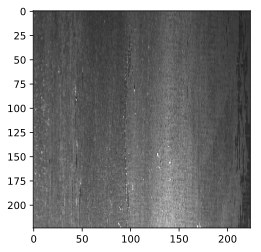

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

plt.imshow(t_img)
plt.show()

In [7]:
#处理最后测试集
#最终目的是去掉所有的不含缺陷的图片（通过其他模型单独训练）

from keras.preprocessing.image import ImageDataGenerator

sub_df = pandas.read_csv('D:/data/Kaggle/Severstal/sample_submission.csv')
sub_df['ImageId'] = sub_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
sub_df.head()

Using TensorFlow backend.


,ImageId_ClassId,EncodedPixels,ImageId
0,004f40c73.jpg_1,1 1,004f40c73.jpg
1,004f40c73.jpg_2,1 1,004f40c73.jpg
2,004f40c73.jpg_3,1 1,004f40c73.jpg
3,004f40c73.jpg_4,1 1,004f40c73.jpg
4,006f39c41.jpg_1,1 1,006f39c41.jpg


In [8]:
test_imgs = pandas.DataFrame(sub_df['ImageId'].unique(), columns=['ImageId'])#只根据图片名称建表
print(len(test_imgs))
test_imgs.head()

1801


,ImageId
0,004f40c73.jpg
1,006f39c41.jpg
2,00b7fb703.jpg
3,00bbcd9af.jpg
4,0108ce457.jpg


In [11]:
#测试集的生成器

BATCH_SIZE = 64

test_gen = ImageDataGenerator(rescale=1/255.).flow_from_dataframe(
        test_imgs,
        directory=r'D:\data\Kaggle\Severstal/test_imgs', #目标目录的路径，如果写了要包含在 dataframe 中映射的所有图像
        x_col='ImageId',
        class_mode=None,
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        shuffle=False #不打乱顺序
    )

#test_gen = create_test_gen()

Found 1801 images.


In [43]:
#使用预训练的模型去除没有缺陷的测试集图片

from keras.models import Model, load_model

remove_model = load_model('D:/data/Kaggle/Severstal/pre_model_2.h5')
remove_model.summary()

KeyboardInterrupt: 

In [12]:
#利用预测生成器，将无缺陷的测试图片剔除

test_missing_pred = remove_model.predict_generator(
    test_gen,
    steps=len(test_gen),
    verbose=1
)

test_imgs['allMissing'] = test_missing_pred #allMissing列值等于1代表没有给定的缺陷类型，即无缺陷
test_imgs.head()

29/29 [==============================] - 701s 24s/step


,ImageId,allMissing
0,004f40c73.jpg,0.366607
1,006f39c41.jpg,0.999998
2,00b7fb703.jpg,0.996744
3,00bbcd9af.jpg,0.000466
4,0108ce457.jpg,0.999995


In [45]:
test_missing_pred.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [14]:
#测试集中所有含有至少1类缺陷的图片
filtered_test_imgs = test_imgs[test_imgs['allMissing'] < 0.5]
print(filtered_test_imgs.shape)
filtered_test_imgs.head()

(393, 2)


,ImageId,allMissing
0,004f40c73.jpg,0.366607
3,00bbcd9af.jpg,0.000466
5,0109b68ec.jpg,0.324224
8,017bd7ce3.jpg,0.217356
9,01b47d973.jpg,0.001480


In [15]:
#将给定的缺陷标注方法复制到选出的图片上
filtered_mask = sub_df['ImageId'].isin(filtered_test_imgs["ImageId"].values)
filtered_sub_df = sub_df[filtered_mask].copy()
print(filtered_sub_df.shape)
filtered_sub_df.head()

(1572, 3)


,ImageId_ClassId,EncodedPixels,ImageId
0,004f40c73.jpg_1,1 1,004f40c73.jpg
1,004f40c73.jpg_2,1 1,004f40c73.jpg
2,004f40c73.jpg_3,1 1,004f40c73.jpg
3,004f40c73.jpg_4,1 1,004f40c73.jpg
12,00bbcd9af.jpg_1,1 1,00bbcd9af.jpg


In [16]:
#上面的取反即为测试集无缺陷的图片
null_sub_df = sub_df[~filtered_mask].copy()
null_sub_df['EncodedPixels'] = null_sub_df['EncodedPixels'].apply(lambda x: ' ')
null_sub_df.head()

,ImageId_ClassId,EncodedPixels,ImageId
4,006f39c41.jpg_1,,006f39c41.jpg
5,006f39c41.jpg_2,,006f39c41.jpg
6,006f39c41.jpg_3,,006f39c41.jpg
7,006f39c41.jpg_4,,006f39c41.jpg
8,00b7fb703.jpg_1,,00b7fb703.jpg


In [39]:
#测试下和直接取>0.5的结果有无不同
#基本一样
filtered_test_imgs_binary = test_imgs[test_imgs['allMissing'] > 0.5]
filtered_mask_binary = sub_df['ImageId'].isin(filtered_test_imgs_binary["ImageId"].values)
filtered_sub_df_binary = sub_df[filtered_mask_binary].copy()
filtered_sub_df_binary.head()

,ImageId_ClassId,EncodedPixels,ImageId
4,006f39c41.jpg_1,1 1,006f39c41.jpg
5,006f39c41.jpg_2,1 1,006f39c41.jpg
6,006f39c41.jpg_3,1 1,006f39c41.jpg
7,006f39c41.jpg_4,1 1,006f39c41.jpg
8,00b7fb703.jpg_1,1 1,00b7fb703.jpg


In [40]:
print(filtered_sub_df_binary.loc[4,'ImageId'])
print(filtered_sub_df_binary['ImageId'].iloc[4])

006f39c41.jpg
00b7fb703.jpg


In [17]:
#重排下index
filtered_sub_df.reset_index(drop=True, inplace=True)
filtered_test_imgs.reset_index(drop=True, inplace=True)

print(filtered_sub_df.shape)
print(null_sub_df.shape)

filtered_sub_df.head()

(1572, 3)
(5632, 3)


,ImageId_ClassId,EncodedPixels,ImageId
0,004f40c73.jpg_1,1 1,004f40c73.jpg
1,004f40c73.jpg_2,1 1,004f40c73.jpg
2,004f40c73.jpg_3,1 1,004f40c73.jpg
3,004f40c73.jpg_4,1 1,004f40c73.jpg
4,00bbcd9af.jpg_1,1 1,00bbcd9af.jpg


In [65]:
np_img = load_img('db4867ee8.jpg','D:\data\Kaggle\Severstal/train_imgs')
#print(type(np_img))
f_img = np_img.T.flatten() #224*224*3 =>3 *224 *224
print(f_img.shape)
pixels = np.concatenate([[0], f_img, [0]])
print(pixels)
pixels_need = np.where(pixels[1:] != pixels[:-1])[0]+1
print(pixels_need)
m = pixels_need[1::2] - pixels_need[::2] 
pixels_need[1::2] = m
pixels_need

(150528,)
[ 0 32 33 ...  2  2  0]
[     1      2      3 ... 150515 150525 150529]


ValueError: operands could not be broadcast together with shapes (66828,) (66829,) 

In [91]:
l =np.zeros((*(2,2),3))
print(l)
l2 = np.array([[1,2,1],[5,2,4],[3,3,3]])
print(l2.shape)
print(l2)
l2[:,1]

[[[0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]]]
(3, 3)
[[1 2 1]
 [5 2 4]
 [3 3 3]]


array([2, 2, 3])

In [41]:
#绘制区域相关的函数

def mask2rle(img): #返回缺陷区域起点和经过的长度，即项目要求的覆盖表示方法（EncodedPixels）
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten() #行列互换并展平
    pixels = np.concatenate([[0], pixels, [0]]) #拼接多个数组，传入的数组必须具有相同的形状。默认axis=0，增加行数，若axis=1，则在原有数组行延伸
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1 #返回所有点的索引,并全部+1。本次项目像素起点为（1，1），所以要设置+1
    runs[1::2] -= runs[::2] #将第偶数个点换为这个点减上个点的差，即项目要求的长度
    return ' '.join(str(x) for x in runs) #返回缺陷左边的起点和长度，用空格分开

def rle2mask(rle, input_shape): #将缺陷区域的原始坐标表示方法（EncodedPixels）进行处理。转化为值设为1，再转换为2维坐标
    width, height = input_shape[:2]#去掉depth层的维度
    #shape = input_shape[:2] #(256,1600)
    
    mask= np.zeros( width*height ).astype(np.uint8) #展平，一维张量
    #mask = np.zeros(shape[0]*shape[1], dtype=np.uint8) #展平，一维张量
    
    array = np.asarray([int(x) for x in rle.split()]) #将缺陷区域的坐标格式分离
    starts = array[0::2]
    lengths = array[1::2]
    
    starts = starts - 1 #因为起始值是1，所以先要把坐标减一下
    ends = starts + lengths
    
    #current_position = 0    
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1 #将所有有缺陷的像素点的值设为1，无缺陷的点为0
        
    #return mask.reshape(height, width).T
    return mask.reshape(width, height).T

#     for lo, hi in zip(starts, ends):
#         mask[lo:hi] = 1
#     return mask.reshape(shape)


def build_masks(rles, input_shape): #注意传入的rles是一组4个数，因为不一定哪个缺陷类下有数据。传入含有缺陷的坐标组（EncodedPixels）和图片原始宽长，生成标记缺陷的覆盖
    depth = len(rles) 
    height, width = input_shape
    masks = np.zeros((*input_shape, depth)) #*号是延伸的意思。即生成(input_shape.extend(depth))形状0矩阵
    #masks = np.zeros((height, width, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str: #因为如果没有rle数据（没有该类缺陷）的话，该单元格的数据是nan，即浮点型
            #masks[:, :, i] = rle2mask(rle, input_shape) #按层数depth遍历，i值代表对应缺陷类的编号
            masks[:, :, i] = rle2mask(rle, (width, height))
    
    return masks

def build_rles(masks): #生成项目要求的坐标表示（EncodedPixels），调用上面的mask2rle函数
    width, height, depth = masks.shape
    
    rles = [mask2rle(masks[:, :, i]) for i in range(depth)]
    
    return rles

print(train_df.loc[0,'EncodedPixels'])
mask_tensor = rle2mask(train_df.loc[0,'EncodedPixels'], (256,1600,1))
print(mask_tensor, mask_tensor.shape)
print(mask2rle(rle2mask(train_df.loc[0,'EncodedPixels'], (256,1600,1))))
mask2rle(rle2mask('1 1',((256,1600,1))))

29102 12 29346 24 29602 24 29858 24 30114 24 30370 24 30626 24 30882 24 31139 23 31395 23 31651 23 31907 23 32163 23 32419 23 32675 23 77918 27 78174 55 78429 60 78685 64 78941 68 79197 72 79452 77 79708 81 79964 85 80220 89 80475 94 80731 98 80987 102 81242 105 81498 105 81754 104 82010 104 82265 105 82521 31 82556 69 82779 27 82818 63 83038 22 83080 57 83297 17 83342 50 83555 13 83604 44 83814 8 83866 37 84073 3 84128 31 84390 25 84652 18 84918 8 85239 10 85476 29 85714 47 85960 57 86216 57 86471 58 86727 58 86983 58 87238 59 87494 59 87750 59 88005 60 88261 60 88517 60 88772 61 89028 53 89283 40 89539 32 89667 10 89795 30 89923 28 90050 29 90179 37 90306 27 90434 38 90562 14 90690 38 90817 9 90946 38 91073 3 91202 38 91458 38 91714 38 91969 39 92225 39 92481 39 92737 39 92993 39 93248 40 93504 40 93760 40 94026 30 94302 10 189792 7 190034 21 190283 28 190539 28 190795 28 191051 28 191307 28 191563 28 191819 28 192075 28 192331 28 192587 28 192843 23 193099 14 193355 5
[[0 0 0 ... 0 

'2 1'

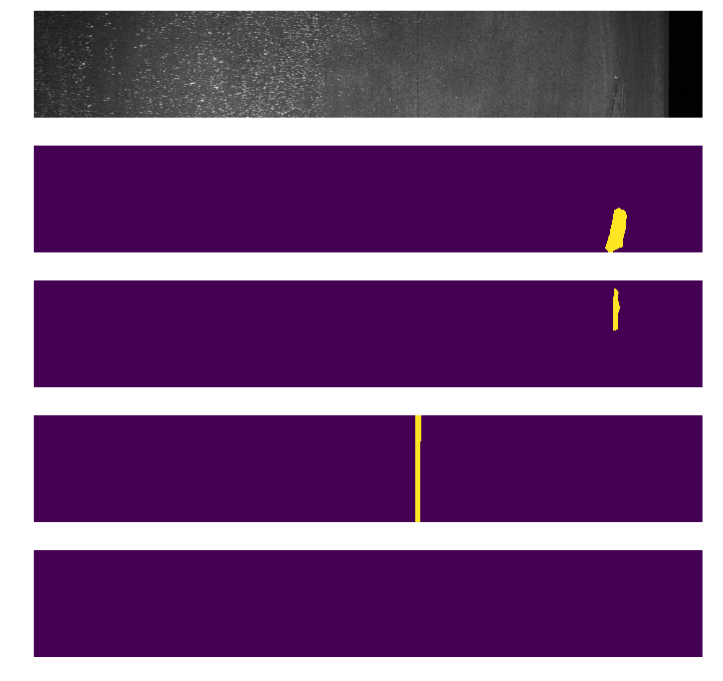

In [40]:
#查看缺陷区域范围
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

t_img_name ='db4867ee8.jpg'
sample_image_df = train_df[train_df['ImageId'] == t_img_name]
sample_path = "D:/data/Kaggle/Severstal/train_imgs/{}".format(t_img_name)
sample_img = cv2.imread(sample_path)
sample_rles = sample_image_df['EncodedPixels'].values
sample_masks = build_masks(sample_rles, input_shape=(256, 1600))

fig, axs = plt.subplots(5, figsize=(12, 12))
#print(axs)
axs[0].imshow(sample_img)
axs[0].axis('off')

for i in range(4):
    axs[i+1].imshow(sample_masks[:, :, i])
    axs[i+1].axis('off')

In [20]:
#使用生成器作为数据来源，这么做主要还是为了提高效率，不用ImageDataGenerator是为了能自定义覆盖层
#主要设置__generate_X，__generate_y两个函数

import keras
from keras.models import Sequential

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='D:/data/Kaggle/Severstal/train_imgs',
                 batch_size=32, dim=(256, 1600), n_channels=1, #dim是原始图片大小，width*length
                 n_classes=4, random_state=1444, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        
        self.on_epoch_end() #这行不要忘了

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size] #生成每个批次的index

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch) #获取特征值X
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch) #获取返回值y
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self): #在一个epoch开始时或者结束时触发
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True: #打乱数据，每次batch结束后重新随机另个index
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch): #生成array格式的灰度图片，并存储在列表中
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels)) #创建传入参数维度的随机数组成的矩阵
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID] #应该也可以写成df.loc[i,'ImageId']
            img_path = f"{self.base_path}/{im_name}"
            img = self.__load_grayscale(img_path)
            
            # Store samples
            X[i,] = img
        return X
    
    def __generate_y(self, list_IDs_batch): #生成每张图缺陷对应坐标的1/0二维表示并存储，同时标记了类别（深度）
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID] 
            image_df = self.target_df[self.target_df['ImageId'] == im_name]
            
            rles = image_df['EncodedPixels'].values #这里返回的是含有各个类别缺陷标记的数组（4个）
            masks = build_masks(rles, input_shape=self.dim)
            
            y[i, ] = masks

        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)
        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.
        return img

In [21]:
#划分训练集和验证集
#train_df: 图片id和对应的缺陷类别，及缺陷的坐标（图片id有重复）
#mask_count_df: 统计了每张图的缺欠总数（包含无缺陷的图片），并且标注了每张图缺陷类别的数量
#non_missing_train_idx: 所有的带缺陷图片合集，并且标注了缺陷种类的数量

from sklearn.model_selection import train_test_split #返回划分好的训练集测试集样本和训练集测试集标签

BATCH_SIZE = 16

train_idx, val_idx = train_test_split(
    non_missing_train_idx.index,  # 之前在原始训练集选好的图片中挑出的有缺陷df里，划分出训练集和验证集
    #mask_count_df.index, #包含无缺陷的图片的每张图的缺欠总数，并且标注了每张图缺陷类别的数量
    random_state=1444, #是随机数的种子，就是如果填0就是每次随机数都不一样，不是零就是固定随机数
    test_size=0.15 #如果是浮点数，在0-1之间，表示验证占比；如果是整数的话就是数量
)

train_generator = DataGenerator(
    train_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    n_classes=4
)

val_generator = DataGenerator(
    val_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    n_classes=4
)

In [114]:
from keras import backend as K

a = K.flatten(np.array([[1,2],[3,4],[5,6]]))
b = K.flatten(np.array([[4,2,1],[3,7,2]]))
print(b)
v = K.variable(value=b, dtype='int32')
print(v)
ev = K.eval(v)
print(ev)

c = K.sum(a*b) #这里是一一对应相乘，其实就是向量的乘法。c等于ab两向量对应相乘再相加
print(K.eval(c))


from keras.layers import Add, Multiply

t1 = K.variable(np.array([[1,2],[3,4],[5,6]]), dtype='int32')
t2 = K.variable(np.array([[1,2],[3,4],[5,7]]), dtype='int32')
#t2 = K.variable(np.array([[4,2,1],[3,7,2]]), dtype='int32')
add = Add()([t1,t2])
mul = Multiply()([t1,t2]) #只能对应相乘，并非矩阵乘法
print('add：',K.eval(add),'multi：',K.eval(mul))

#矩阵乘法
np.dot(np.array([[1,2],[3,4],[5,7]]), np.array([[4,2,1],[3,7,2]]))

Tensor("Reshape_38:0", shape=(6,), dtype=int32)
<tf.Variable 'Variable_20:0' shape=(6,) dtype=int32_ref>
[4 2 1 3 7 2]
70
add： [[ 2  4]
 [ 6  8]
 [10 13]] multi： [[ 1  4]
 [ 9 16]
 [25 42]]


array([[10, 16,  5],
       [24, 34, 11],
       [41, 59, 19]])

In [22]:
#使用项目规定的评定计算方法
#利用keras自带的张量计算方法，dice coefficient，在图像识别领域经常用于识别图像间的相似度（重叠度）

from keras.losses import binary_crossentropy

def dice_coef(y_true, y_pred, smooth=1): #用于模型的准确度评价，其实是个图像识别的专用评价标准，戴斯相似系数。分母是两个向量的长度和
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth) #这里+1是项目规定x,y都为空时相似度为1

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [35]:
#建模，使用函数式api构造模型结构

from keras.models import Model, load_model
from keras.layers import Input
from keras import backend as K
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate

inputs = Input((256, 1600, 1)) #原图尺寸，黑白单通道

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (c5)
p5 = MaxPooling2D(pool_size=(2, 2)) (c5) #到这里一直是在对原始的input进行层操作变换

c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (p5) #开始对原始的input进行变换，直到u6的反向卷积
c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (c55)

#应该是使用了残差连接，用于避免梯度消失和表示瓶颈
u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55) #转置卷积层 (有时被成为反卷积)，将具有该卷积层输出shape的tensor转换为具有该卷积层输入shape的tensor。同时保留与卷积层兼容的连接模式
u6 = concatenate([u6, c5]) #和上一步在一起，相当于降维后连结在一起，和之前的维度相同。默认axis=-1(最后一个轴)，相当于按照c5[-1轴],u6[-1轴]拼接，即
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u71 = concatenate([u71, c4])
c71 = Conv2D(32, (3, 3), activation='relu', padding='same') (u71)
c61 = Conv2D(32, (3, 3), activation='relu', padding='same') (c71)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef])#使用之前写的评分函数
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 1600, 1) 0                                            
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 256, 1600, 8) 80          input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 256, 1600, 8) 584         conv2d_47[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_11 (MaxPooling2D) (None, 128, 800, 8)  0           conv2d_48[0][0]                  
__________________________________________________________________________________________________
conv2d_49 

In [42]:
#拟合模型
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau

checkpoint = ModelCheckpoint(
    'D:/data/Kaggle/Severstal/model_1.1.h5', 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint],
    use_multiprocessing=False,
    workers=1,
    epochs=10
)

Epoch 1/10
 54/354 [===>..........................] - ETA: 1:11:39 - loss: 1.1175 - dice_coef: 6.7761e-06

KeyboardInterrupt: 

In [26]:
model.save('D:/data/Kaggle/Severstal/model_1.2.h5')

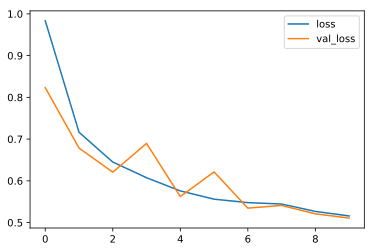

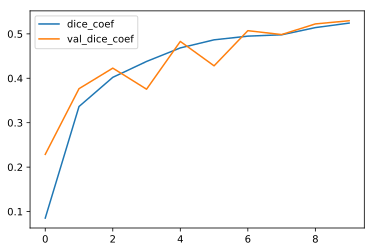

In [27]:
history_df = pandas.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['dice_coef', 'val_dice_coef']].plot()

In [132]:
import gc
from tqdm import tqdm

model.load_weights('model.h5')
test_df = []

for i in range(0, filtered_test_imgs.shape[0], 200):
    batch_idx = list(
        range(i, min(filtered_test_imgs.shape[0], i + 200))
    )
    
    test_generator = DataGenerator(
        batch_idx,
        df=filtered_test_imgs,
        shuffle=False,
        mode='predict',
        base_path='D:/data/Kaggle/Severstal/test_imgs',
        target_df=filtered_sub_df,
        batch_size=1,
        n_classes=4
    )
    
    batch_pred_masks = model.predict_generator(
        test_generator, 
        workers=1,
        verbose=0,
        use_multiprocessing=False
    )
    
    for j, b in tqdm(enumerate(batch_idx)):
        filename = filtered_test_imgs['ImageId'].iloc[b]
        image_df = filtered_sub_df[filtered_sub_df['ImageId'] == filename].copy()
        
        pred_masks = batch_pred_masks[j, ].round().astype(int) #round()是numpy的函数，是将张量内的所有元素五舍六入到整数
        pred_rles = build_rles(pred_masks)
        
        image_df['EncodedPixels'] = pred_rles
        test_df.append(image_df)
        
    gc.collect()

200/200 [==============================] - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 59 - ETA: 59 - ETA: 58 - ETA: 58 - ETA: 58 - ETA: 57 - ETA: 57 - ETA: 57 - ETA: 56 - ETA: 56 - ETA: 55 - ETA: 55 - ETA: 55 - ETA: 54 - ETA: 54 - ETA: 54 - ETA: 53 - ETA: 53 - ETA: 52 - ETA: 52 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 50 - ETA: 50 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 47 - ETA: 47 - ETA: 46 - ETA: 46 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 42 - ETA: 42 - ETA: 41 - ETA: 41 - ETA: 41 - ETA: 4

200it [00:16, 12.50it/s]


121/121 [==============================] - ETA: 49 - ETA: 48 - ETA: 49 - ETA: 48 - ETA: 47 - ETA: 46 - ETA: 45 - ETA: 44 - ETA: 44 - ETA: 43 - ETA: 42 - ETA: 42 - ETA: 42 - ETA: 42 - ETA: 42 - ETA: 42 - ETA: 41 - ETA: 41 - ETA: 40 - ETA: 40 - ETA: 39 - ETA: 39 - ETA: 38 - ETA: 38 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 35 - ETA: 35 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 33 - ETA: 33 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 31 - ETA: 31 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 29 - ETA: 29 - ETA: 28 - ETA: 28 - ETA: 27 - ETA: 27 - ETA: 27 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 25 - ETA: 25 - ETA: 24 - ETA: 24 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 21 - ETA: 21 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 19 - ETA: 19 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 17 - ETA: 17 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 15 - ETA: 15 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 9 

121it [00:09, 12.30it/s]


In [ ]:
# 单模型预测
import gc
from tqdm import tqdm
from keras.models import load_model

model.load_weights('../input/model-single-api/model_1.2.h5')
test_df = []

for i in range(0, test_imgs.shape[0], 200):
    batch_idx = list(
        range(i, min(test_imgs.shape[0], i + 200))
    )
    
    test_generator = DataGenerator(
        batch_idx,
        df=test_imgs,
        shuffle=False,
        
        mode='predict',
        base_path='../input/severstal-steel-defect-detection/test_images',
        target_df=sub_df,
        batch_size=1,
        n_classes=4
    )
    
    batch_pred_masks = model.predict_generator(
        test_generator, 
        workers=1,
        verbose=1,
        use_multiprocessing=False
    )
    
    for j, b in tqdm(enumerate(batch_idx)):
        filename = test_imgs['ImageId'].iloc[b]
        image_df = sub_df[sub_df['ImageId'] == filename].copy()
        
        pred_masks = batch_pred_masks[j, ].round().astype(int)
        pred_rles = build_rles(pred_masks)
        
        image_df['EncodedPixels'] = pred_rles
        test_df.append(image_df)
        
    gc.collect()

In [133]:
test_df = pandas.concat(test_df)
print(test_df.shape)
test_df.head()

(1284, 3)


,ImageId_ClassId,EncodedPixels,ImageId
0,004f40c73.jpg_1,,004f40c73.jpg
1,004f40c73.jpg_2,,004f40c73.jpg
2,004f40c73.jpg_3,,004f40c73.jpg
3,004f40c73.jpg_4,,004f40c73.jpg
4,00b7fb703.jpg_1,,00b7fb703.jpg


In [135]:
final_submission_df = pandas.concat([test_df, null_sub_df])
print(final_submission_df.shape)
final_submission_df.head(20)

(7204, 3)


,ImageId_ClassId,EncodedPixels,ImageId
0,004f40c73.jpg_1,,004f40c73.jpg
1,004f40c73.jpg_2,,004f40c73.jpg
2,004f40c73.jpg_3,,004f40c73.jpg
3,004f40c73.jpg_4,,004f40c73.jpg
4,00b7fb703.jpg_1,,00b7fb703.jpg
5,00b7fb703.jpg_2,,00b7fb703.jpg
6,00b7fb703.jpg_3,20785 1 20801 1 20809 1 20813 1 20817 1 20821 ...,00b7fb703.jpg
7,00b7fb703.jpg_4,,00b7fb703.jpg
8,0108ce457.jpg_1,,0108ce457.jpg
9,0108ce457.jpg_2,,0108ce457.jpg


In [17]:
# 将1 1替换为空，能提高评分
for index in final_submission_df.index:
    e_pixels = str(final_submission_df['EncodedPixels'].iloc[index])
    #print(e_pixels)
    if e_pixels == '1 1' and len(e_pixels) < 5:
        final_submission_df['EncodedPixels'].iloc[index] = ''
    else: pass
#final_submission_df['EncodedPixels'] = final_submission_df['EncodedPixels'].apply(lambda x: x.replace('1 1','')) 
final_submission_df.head(20)

NameError: name 'final_submission_df' is not defined

In [136]:
final_submission_df[['ImageId_ClassId', 'EncodedPixels']].to_csv('D:/data/Kaggle/Severstal/submission_first.csv', index=False)